In [1]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import torch
from dreamsim import dreamsim
from utils_new import generate_mask_and_extract_tensor
from grounding_sam_utils import GroundingSAM

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


final text_encoder_type: bert-base-uncased


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

repo_id = "ShilongLiu/GroundingDINO"
dino_checkpoint_filename = "groundingdino_swinb_cogcoor.pth"
dino_config_filename = "GroundingDINO_SwinB.cfg.py"

sam_checkpoint_path = '/teamspace/studios/this_studio/metafaces_UI/Grounded_Segment_Anything/sam_vit_h_4b8939.pth'

# Load models
dino_model = GroundingSAM.load_grounding_dino(repo_id, dino_checkpoint_filename, dino_config_filename, device=device)

sam_model = GroundingSAM.load_sam(sam_checkpoint_path, device=device)

# Create an instance of GroundingSAM
grounding_sam = GroundingSAM(dino_model=dino_model, sam_model=sam_model, device=device)

final text_encoder_type: bert-base-uncased


In [5]:
def evaluate_clip_similarity(image_url, text_prompts):
    """
    Classify an image using OpenAI's CLIP model with given text prompts.

    Args:
        image_url (str): URL of the image to classify.
        text_prompts (list): List of text descriptions (e.g., ["a photo of a cat", "a photo of a dog"]).

    Returns:
        logits_per_image (torch.Tensor): Raw similarity scores for each prompt.
        probs (torch.Tensor): Normalized probabilities after softmax.
    """
    # Load model and processor
    model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
    
    # Load image
    image = Image.open(image_url)

    # Preprocess
    inputs = processor(text=text_prompts, images=image, return_tensors="pt", padding=True)

    # Forward pass
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1)

    return logits_per_image, probs

In [6]:
image_url = '/teamspace/studios/this_studio/generated/scene_1.png'
text_prompts = 'a girl sitting under a glowing lamp in a cozy room, reading a storybook to her attentive cat.'

In [7]:
logits_per_image, probs = evaluate_clip_similarity(image_url, text_prompts)
# logits_per_image
probs

tensor([[1.]], grad_fn=<SoftmaxBackward0>)

In [4]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from dreamsim import dreamsim  # or your correct import
# from your_module import generate_mask_and_extract_tensor, grounding_sam

def evaluate_dreamsim_similarity(anchor_image, scene_image, prompt, device, visualize=False):
    """
    Computes DreamSim similarity between an anchor and the segmented character from a scene image.
    Optionally shows the anchor and cropped images.
    """
    model, preprocess = dreamsim(pretrained=True, device=device)

    # Load and preprocess scene image
    scene_image_np = np.array(Image.open(scene_image).convert("RGB"))
    scene_tensor = torch.from_numpy(scene_image_np).permute(2, 0, 1).float() / 255.0
    scene_tensor = scene_tensor.to(device)

    # Character extraction
    cropped_tensor, _, cropped_image, _ = generate_mask_and_extract_tensor(
        scene_tensor, grounding_sam, prompt, device
    )

    # Load images
    anchor_pil = Image.open(anchor_image)
    cropped_pil = Image.fromarray(cropped_image)

    # Optionally visualize
    if visualize:
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(anchor_pil)
        axs[0].set_title("Anchor Image")
        axs[0].axis("off")

        axs[1].imshow(cropped_pil)
        axs[1].set_title("Cropped Character")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()

    # Preprocess for DreamSim model
    img1 = preprocess(anchor_pil).to(device)
    img2 = preprocess(cropped_pil).to(device)

    with torch.no_grad():
        distance = model(img1, img2)

    return distance.item()


Using cached ./models


Using cache found in ./models/facebookresearch_dino_main


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Cropping character region at (528, 352) to (1023, 1023)


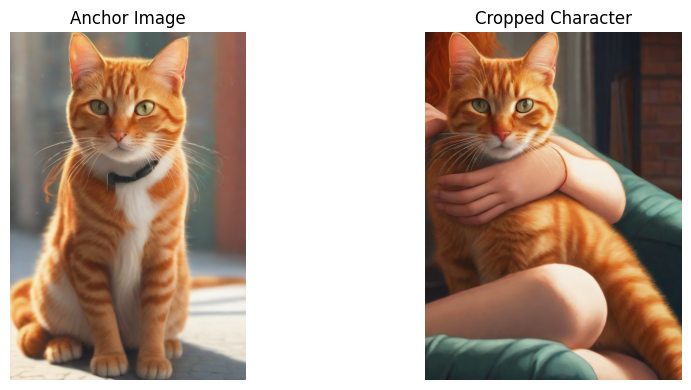

DreamSim similarity distance: 0.2440


In [5]:
distance = evaluate_dreamsim_similarity(
    anchor_image="/teamspace/studios/this_studio/generated/anchor_1.png",
    scene_image="/teamspace/studios/this_studio/generated/scene_1.png",
    prompt="a tabby cat",
    device=torch.device("cuda"),
    visualize=True
)
print(f"DreamSim similarity distance: {distance:.4f}")